In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,mean_absolute_percentage_error
from tqdm import tqdm


In [15]:
with open('/home/f20222001/test-venv/UHI/Datasets_processed/inputs_36_extra_clean_40k_hyd.pkl', 'rb') as f, open('/home/f20222001/test-venv/UHI/Datasets_processed/targets_36_extra_clean_40k_hyd.pkl','rb') as t:
    inputs = pickle.load(f)
    targets = pickle.load(t)
# Shuffle before splitting (preserves alignment of X and y)
X_shuffled, y_shuffled = shuffle(inputs, targets, random_state=42)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_shuffled, y_shuffled, test_size=0.2, random_state=42
)
# X_train, X_test, Y_train, Y_test = train_test_split(
#     X_train, Y_train, test_size=0.2, random_state=42
# )
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.25, random_state=42
)

In [16]:
# Indexes of features to normalize
norm_idx = [0, 1, 2, 3] 

# Flatten for scaling
X_train_flat = X_train.reshape(-1, X_train.shape[2])
X_val_flat   = X_val.reshape(-1, X_val.shape[2])
X_test_flat  = X_test.reshape(-1, X_test.shape[2])

# Initialize arrays to hold the scaled data
X_train_scaled = X_train_flat.copy()
X_val_scaled   = X_val_flat.copy()
X_test_scaled  = X_test_flat.copy()

scaler = StandardScaler()

# Fit on train, transform all
X_train_scaled[:, norm_idx] = scaler.fit_transform(X_train_flat[:, norm_idx])
X_val_scaled[:, norm_idx]   = scaler.transform(X_val_flat[:, norm_idx])
X_test_scaled[:, norm_idx]  = scaler.transform(X_test_flat[:, norm_idx])

# Reshape back to 3D
X_train = X_train_scaled.reshape(X_train.shape)
X_val   = X_val_scaled.reshape(X_val.shape)
X_test  = X_test_scaled.reshape(X_test.shape)

# Flatten y
y_train_flat = Y_train.reshape(-1, 1)
y_val_flat   = Y_val.reshape(-1, 1)
y_test_flat  = Y_test.reshape(-1, 1)

# Standardize y
standard_scaler_y = StandardScaler()
y_train_scaled = standard_scaler_y.fit_transform(y_train_flat)
y_val_scaled   = standard_scaler_y.transform(y_val_flat)
y_test_scaled  = standard_scaler_y.transform(y_test_flat)

# Reshape back to original shape
Y_train = y_train_scaled.reshape(Y_train.shape)
Y_val   = y_val_scaled.reshape(Y_val.shape)
Y_test  = y_test_scaled.reshape(Y_test.shape)


In [17]:
X_train.shape

(152607, 36, 7)

In [18]:
X_train

array([[[-1.3677800e-01,  2.7815565e-01,  5.0455469e-01, ...,
          5.0000000e-01,  8.6602539e-01,  1.5700000e+02],
        [ 8.9764833e-01, -1.0932604e-01,  1.0105546e+00, ...,
          8.6602539e-01, -5.0000000e-01,  1.6000000e+02],
        [ 1.0415890e+00, -3.4918717e-01,  6.4548796e-01, ...,
          5.0000000e-01, -8.6602539e-01,  1.6100000e+02],
        ...,
        [-5.0806504e-01,  1.1837535e+00, -5.7403439e-01, ...,
          5.0000000e-01,  8.6602539e-01,  2.1700000e+02],
        [-1.0610006e-01,  8.7832403e-01, -2.9817352e-01, ...,
          8.6602539e-01,  5.0000000e-01,  2.1800000e+02],
        [ 2.5902390e-01,  4.8388737e-01,  1.2373154e-01, ...,
          1.0000000e+00,  6.1232343e-17,  2.1900000e+02]],

       [[-6.4995110e-01,  1.1242990e+00, -2.0170493e+00, ...,
         -8.6602539e-01,  5.0000000e-01,  1.0000000e+01],
        [-6.8104005e-01, -4.2843637e-01, -9.6082604e-01, ...,
         -2.4492937e-16,  1.0000000e+00,  1.2000000e+01],
        [-1.5321274e-01, 

In [19]:
Y_train.shape

(152607,)

In [20]:
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(Y_train, dtype=torch.float32))

val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                            torch.tensor(Y_val, dtype=torch.float32))

test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(Y_test, dtype=torch.float32))

# Create loaders
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [21]:
device = torch.device("cuda")
device

device(type='cuda')

In [22]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=1536, num_layers=3, dropout=0.3):
        super(LSTMPredictor, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )

        self.fc = nn.Linear(hidden_size, 1)  # Output = scalar

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_size)
        last_time_step = lstm_out[:, -1, :]  # take the last time step's output
        out = self.fc(last_time_step)  # (batch_size, 1)
        return out.squeeze(1)  # final shape: (batch_size,)
    


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100 - Train Loss: 0.5061970353126526


  1%|          | 1/100 [00:19<32:43, 19.84s/it]

Epoch 2/100 - Train Loss: 0.22727830708026886


  2%|▏         | 2/100 [00:39<32:30, 19.90s/it]

Epoch 3/100 - Train Loss: 0.3370833694934845


  3%|▎         | 3/100 [00:59<32:19, 20.00s/it]

Epoch 4/100 - Train Loss: 0.13458369672298431


  4%|▍         | 4/100 [01:19<32:00, 20.01s/it]

Epoch 5/100 - Train Loss: 0.08864545822143555


  5%|▌         | 5/100 [01:39<31:42, 20.03s/it]

Epoch 6/100 - Train Loss: 0.09836732596158981


  6%|▌         | 6/100 [02:00<31:27, 20.08s/it]

Epoch 7/100 - Train Loss: 0.1246304139494896


  7%|▋         | 7/100 [02:20<31:11, 20.12s/it]

Epoch 8/100 - Train Loss: 0.09750087559223175


  8%|▊         | 8/100 [02:40<30:49, 20.11s/it]

Epoch 9/100 - Train Loss: 0.22093051671981812


  9%|▉         | 9/100 [03:00<30:29, 20.11s/it]

Epoch 10/100 - Train Loss: 0.051952723413705826


 10%|█         | 10/100 [03:20<30:13, 20.15s/it]

Epoch 11/100 - Train Loss: 0.1084139496088028


 11%|█         | 11/100 [03:40<29:51, 20.12s/it]

Epoch 12/100 - Train Loss: 0.1095881462097168


 12%|█▏        | 12/100 [04:00<29:31, 20.13s/it]

Epoch 13/100 - Train Loss: 0.08903513103723526


 13%|█▎        | 13/100 [04:21<29:13, 20.16s/it]

Epoch 14/100 - Train Loss: 0.0826605036854744


 14%|█▍        | 14/100 [04:41<28:55, 20.18s/it]

Epoch 15/100 - Train Loss: 0.07032043486833572


 15%|█▌        | 15/100 [05:01<28:33, 20.16s/it]

Epoch 16/100 - Train Loss: 0.08131255954504013


 16%|█▌        | 16/100 [05:21<28:12, 20.15s/it]

Epoch 17/100 - Train Loss: 0.05566079914569855


 17%|█▋        | 17/100 [05:41<27:54, 20.17s/it]

Epoch 18/100 - Train Loss: 0.10868807882070541


 18%|█▊        | 18/100 [06:02<27:32, 20.15s/it]

Epoch 19/100 - Train Loss: 0.11890924721956253


 19%|█▉        | 19/100 [06:22<27:12, 20.15s/it]

Epoch 20/100 - Train Loss: 0.06220071762800217


 20%|██        | 20/100 [06:42<26:54, 20.18s/it]

Epoch 21/100 - Train Loss: 0.03559587895870209


 21%|██        | 21/100 [07:02<26:32, 20.16s/it]

Epoch 22/100 - Train Loss: 0.06097172573208809


 22%|██▏       | 22/100 [07:22<26:12, 20.16s/it]

Epoch 23/100 - Train Loss: 0.1283033937215805


 23%|██▎       | 23/100 [07:42<25:53, 20.18s/it]

Epoch 24/100 - Train Loss: 0.07596246153116226


 24%|██▍       | 24/100 [08:03<25:34, 20.19s/it]

Epoch 25/100 - Train Loss: 0.0319366417825222


 25%|██▌       | 25/100 [08:23<25:11, 20.15s/it]

Epoch 26/100 - Train Loss: 0.060181401669979095


 26%|██▌       | 26/100 [08:43<24:50, 20.15s/it]

Epoch 27/100 - Train Loss: 0.09126865863800049


 27%|██▋       | 27/100 [09:03<24:32, 20.17s/it]

Epoch 28/100 - Train Loss: 0.028502410277724266


 28%|██▊       | 28/100 [09:23<24:13, 20.19s/it]

Epoch 29/100 - Train Loss: 0.010259229689836502


 29%|██▉       | 29/100 [09:43<23:51, 20.16s/it]

Epoch 30/100 - Train Loss: 0.06938498467206955


 30%|███       | 30/100 [10:04<23:32, 20.18s/it]

Epoch 31/100 - Train Loss: 0.08762729167938232


 31%|███       | 31/100 [10:24<23:13, 20.20s/it]

Epoch 32/100 - Train Loss: 0.04992922022938728


 32%|███▏      | 32/100 [10:44<22:51, 20.17s/it]

Epoch 33/100 - Train Loss: 0.016012202948331833


 33%|███▎      | 33/100 [11:04<22:30, 20.16s/it]

Epoch 34/100 - Train Loss: 0.13710349798202515


 34%|███▍      | 34/100 [11:24<22:11, 20.18s/it]

Epoch 35/100 - Train Loss: 0.0979146808385849


 35%|███▌      | 35/100 [11:44<21:49, 20.15s/it]

Epoch 36/100 - Train Loss: 0.023457055911421776


 36%|███▌      | 36/100 [12:05<21:29, 20.15s/it]

Epoch 37/100 - Train Loss: 0.033994872123003006


 37%|███▋      | 37/100 [12:25<21:11, 20.18s/it]

Epoch 38/100 - Train Loss: 0.04807344079017639


 38%|███▊      | 38/100 [12:45<20:52, 20.20s/it]

Epoch 39/100 - Train Loss: 0.04706018418073654


 39%|███▉      | 39/100 [13:05<20:30, 20.17s/it]

Epoch 40/100 - Train Loss: 0.01152360811829567


 40%|████      | 40/100 [13:25<20:09, 20.17s/it]

Epoch 41/100 - Train Loss: 0.07801485806703568


 41%|████      | 41/100 [13:46<19:51, 20.19s/it]

Epoch 42/100 - Train Loss: 0.02897113375365734


 42%|████▏     | 42/100 [14:06<19:31, 20.20s/it]

Epoch 43/100 - Train Loss: 0.029976392164826393


 43%|████▎     | 43/100 [14:26<19:09, 20.17s/it]

Epoch 44/100 - Train Loss: 0.03738237917423248


 44%|████▍     | 44/100 [14:46<18:48, 20.16s/it]

Epoch 45/100 - Train Loss: 0.05123748257756233


 45%|████▌     | 45/100 [15:06<18:29, 20.18s/it]

Epoch 46/100 - Train Loss: 0.046310801059007645


 46%|████▌     | 46/100 [15:26<18:08, 20.15s/it]

Epoch 47/100 - Train Loss: 0.04327559471130371


 47%|████▋     | 47/100 [15:46<17:47, 20.14s/it]

Epoch 48/100 - Train Loss: 0.01768132857978344


 48%|████▊     | 48/100 [16:07<17:28, 20.17s/it]

Epoch 49/100 - Train Loss: 0.0395776629447937


 49%|████▉     | 49/100 [16:27<17:07, 20.14s/it]

Epoch 50/100 - Train Loss: 0.011025389656424522


 50%|█████     | 50/100 [16:47<16:46, 20.14s/it]

Epoch 51/100 - Train Loss: 0.020427284762263298


 51%|█████     | 51/100 [17:07<16:26, 20.14s/it]

Epoch 52/100 - Train Loss: 0.016971386969089508


 52%|█████▏    | 52/100 [17:27<16:08, 20.17s/it]

Epoch 53/100 - Train Loss: 0.020133810117840767


 53%|█████▎    | 53/100 [17:47<15:46, 20.15s/it]

Epoch 54/100 - Train Loss: 0.0193707924336195


 54%|█████▍    | 54/100 [18:07<15:26, 20.14s/it]

Epoch 55/100 - Train Loss: 0.011531819589436054


 55%|█████▌    | 55/100 [18:28<15:07, 20.17s/it]

Epoch 56/100 - Train Loss: 0.012034381739795208


 56%|█████▌    | 56/100 [18:48<14:48, 20.20s/it]

Epoch 57/100 - Train Loss: 0.009973816573619843


 57%|█████▋    | 57/100 [19:08<14:27, 20.16s/it]

Epoch 58/100 - Train Loss: 0.013889155350625515


 58%|█████▊    | 58/100 [19:28<14:06, 20.16s/it]

Epoch 59/100 - Train Loss: 0.014497566036880016


 59%|█████▉    | 59/100 [19:48<13:47, 20.19s/it]

Epoch 60/100 - Train Loss: 0.005374332889914513


 60%|██████    | 60/100 [20:09<13:26, 20.16s/it]

Epoch 61/100 - Train Loss: 0.01167815737426281


 61%|██████    | 61/100 [20:29<13:05, 20.15s/it]

Epoch 62/100 - Train Loss: 0.013734227977693081


 62%|██████▏   | 62/100 [20:49<12:47, 20.19s/it]

Epoch 63/100 - Train Loss: 0.007027426268905401


 63%|██████▎   | 63/100 [21:09<12:26, 20.16s/it]

Epoch 64/100 - Train Loss: 0.010690669529139996


 64%|██████▍   | 64/100 [21:29<12:05, 20.16s/it]

Epoch 65/100 - Train Loss: 0.00534421019256115


 65%|██████▌   | 65/100 [21:49<11:46, 20.19s/it]

Epoch 66/100 - Train Loss: 0.0029874774627387524


 66%|██████▌   | 66/100 [22:10<11:26, 20.21s/it]

Epoch 67/100 - Train Loss: 0.006185725796967745


 67%|██████▋   | 67/100 [22:30<11:05, 20.18s/it]

Epoch 68/100 - Train Loss: 0.011107980273663998


 68%|██████▊   | 68/100 [22:50<10:45, 20.17s/it]

Epoch 69/100 - Train Loss: 0.003610392101109028


 69%|██████▉   | 69/100 [23:10<10:26, 20.19s/it]

Epoch 70/100 - Train Loss: 0.004412600304931402


 70%|███████   | 70/100 [23:30<10:06, 20.20s/it]

Epoch 71/100 - Train Loss: 0.011506491340696812


 71%|███████   | 71/100 [23:51<09:45, 20.17s/it]

Epoch 72/100 - Train Loss: 0.009810945019125938


 72%|███████▏  | 72/100 [24:11<09:24, 20.17s/it]

Epoch 73/100 - Train Loss: 0.008676685392856598


 73%|███████▎  | 73/100 [24:31<09:04, 20.18s/it]

Epoch 74/100 - Train Loss: 0.005690407939255238


 74%|███████▍  | 74/100 [24:51<08:43, 20.15s/it]

Epoch 75/100 - Train Loss: 0.013946388848125935


 75%|███████▌  | 75/100 [25:11<08:23, 20.15s/it]

Epoch 76/100 - Train Loss: 0.005827208515256643


 76%|███████▌  | 76/100 [25:31<08:04, 20.18s/it]

Epoch 77/100 - Train Loss: 0.004630503244698048


 77%|███████▋  | 77/100 [25:52<07:43, 20.15s/it]

Epoch 78/100 - Train Loss: 0.0069107795134186745


 78%|███████▊  | 78/100 [26:12<07:23, 20.15s/it]

Epoch 79/100 - Train Loss: 0.015020599588751793


 79%|███████▉  | 79/100 [26:32<07:03, 20.16s/it]

Epoch 80/100 - Train Loss: 0.007255823351442814


 80%|████████  | 80/100 [26:52<06:43, 20.19s/it]

Epoch 81/100 - Train Loss: 0.004964134190231562


 81%|████████  | 81/100 [27:12<06:23, 20.17s/it]

Epoch 82/100 - Train Loss: 0.004953193012624979


 82%|████████▏ | 82/100 [27:32<06:02, 20.16s/it]

Epoch 83/100 - Train Loss: 0.004835948813706636


 83%|████████▎ | 83/100 [27:53<05:43, 20.19s/it]

Epoch 84/100 - Train Loss: 0.004047998692840338


 84%|████████▍ | 84/100 [28:13<05:23, 20.21s/it]

Epoch 85/100 - Train Loss: 0.0028321093413978815


 85%|████████▌ | 85/100 [28:33<05:02, 20.18s/it]

Epoch 86/100 - Train Loss: 0.004200581461191177


 86%|████████▌ | 86/100 [28:53<04:42, 20.17s/it]

Epoch 87/100 - Train Loss: 0.0032273847609758377


 87%|████████▋ | 87/100 [29:13<04:22, 20.19s/it]

Epoch 88/100 - Train Loss: 0.0015225913375616074


 88%|████████▊ | 88/100 [29:33<04:01, 20.17s/it]

Epoch 89/100 - Train Loss: 0.0030858940444886684


 89%|████████▉ | 89/100 [29:54<03:41, 20.16s/it]

Epoch 90/100 - Train Loss: 0.0027097018901258707


 90%|█████████ | 90/100 [30:14<03:21, 20.19s/it]

Epoch 91/100 - Train Loss: 0.002964332001283765


 91%|█████████ | 91/100 [30:34<03:01, 20.16s/it]

Epoch 92/100 - Train Loss: 0.003495220560580492


 92%|█████████▏| 92/100 [30:54<02:41, 20.15s/it]

Epoch 93/100 - Train Loss: 0.0027782563120126724


 93%|█████████▎| 93/100 [31:14<02:21, 20.17s/it]

Epoch 94/100 - Train Loss: 0.001947413431480527


 94%|█████████▍| 94/100 [31:35<02:01, 20.18s/it]

Epoch 95/100 - Train Loss: 0.0035698325373232365


 95%|█████████▌| 95/100 [31:55<01:40, 20.15s/it]

Epoch 96/100 - Train Loss: 0.0030533019453287125


 96%|█████████▌| 96/100 [32:15<01:20, 20.14s/it]

Epoch 97/100 - Train Loss: 0.005260040517896414


 97%|█████████▋| 97/100 [32:35<01:00, 20.18s/it]

Epoch 98/100 - Train Loss: 0.004708161577582359


 98%|█████████▊| 98/100 [32:55<00:40, 20.19s/it]

Epoch 99/100 - Train Loss: 0.00378028373233974


 99%|█████████▉| 99/100 [33:15<00:20, 20.16s/it]

Epoch 100/100 - Train Loss: 0.0036327268462628126


100%|██████████| 100/100 [33:35<00:00, 20.16s/it]


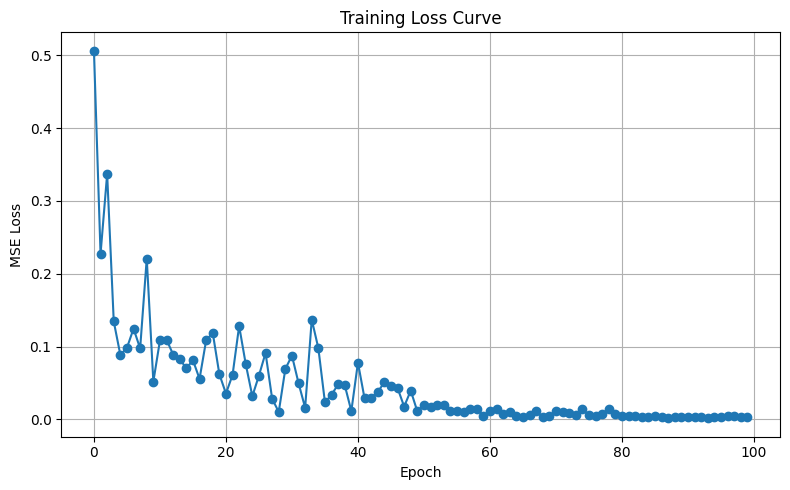

In [23]:
input_size = X_train.shape[2]  # num_features per timestep
model = LSTMPredictor(input_size=input_size)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Training loop
num_epochs = 100
train_losses = []
val_losses = {
    "mse": [],
    "rmse": [],
    "mae": [],
    "r2": []
}

for epoch in tqdm(range(num_epochs)):
    model.train()

    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        #print(batch_x.shape)
        #print(batch_y.shape)
        # Forward
        preds = model(batch_x)  # shape: (batch_size,)
        #print(preds.shape)
        loss = criterion(preds, batch_y)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {loss.item()}")
    train_losses.append(loss.item())

    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for val_x, val_y in val_loader:
            val_x = val_x.to(device)
            val_y = val_y.to(device)

            preds = model(val_x)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(val_y.cpu().numpy())

    # Concatenate and inverse scale
    all_preds_np = np.concatenate(all_preds).reshape(-1, 1)
    all_targets_np = np.concatenate(all_targets).reshape(-1, 1)

    y_pred = standard_scaler_y.inverse_transform(all_preds_np)
    y_true = standard_scaler_y.inverse_transform(all_targets_np)

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    val_losses["mse"].append(mse)
    val_losses["rmse"].append(rmse)
    val_losses["mae"].append(mae)
    val_losses["r2"].append(r2)


plt.figure(figsize=(8, 5))
plt.plot(np.arange(num_epochs),train_losses, marker='o')
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        preds = model(batch_x)
        
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true).reshape(-1, 1)
y_pred = np.array(y_pred).reshape(-1, 1)

# Unnormalize using RobustScaler
y_true = standard_scaler_y.inverse_transform(y_true)
y_pred = standard_scaler_y.inverse_transform(y_pred)

# Flatten back
y_true = y_true.flatten()
y_pred = y_pred.flatten()

# Calculate metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
mape=mean_absolute_percentage_error(y_true, y_pred)
print(f"Test MSE:  {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE:  {mae:.4f}")
print(f"Test R²:   {r2:.4f}")
print(f"Test MAPE:   {mape:.4f}")

Test MSE:  3.3032
Test RMSE: 1.8175
Test MAE:  1.0480
Test R²:   0.9487
Test MAPE:   0.0409


In [25]:
val_losses['mae']

[4.691390037536621,
 3.6675400733947754,
 2.7503838539123535,
 2.4897377490997314,
 2.313765287399292,
 2.2428362369537354,
 2.081237554550171,
 2.25638747215271,
 2.021832227706909,
 1.723854899406433,
 1.7903828620910645,
 1.8082438707351685,
 1.9502390623092651,
 1.9443036317825317,
 1.6385117769241333,
 1.6014227867126465,
 1.5730116367340088,
 1.663374423980713,
 1.526485562324524,
 1.502075433731079,
 1.503846287727356,
 1.4831359386444092,
 1.5838696956634521,
 1.5370241403579712,
 1.4282726049423218,
 1.417569875717163,
 1.398384928703308,
 1.3753432035446167,
 1.447285532951355,
 1.396355390548706,
 1.5857526063919067,
 1.3893184661865234,
 1.3053561449050903,
 1.3981353044509888,
 1.3181676864624023,
 1.2952989339828491,
 1.311005711555481,
 1.2897223234176636,
 1.436346173286438,
 1.2623317241668701,
 1.4285705089569092,
 1.2640035152435303,
 1.2247694730758667,
 1.2319613695144653,
 1.2902480363845825,
 1.3046308755874634,
 1.1853010654449463,
 1.1840128898620605,
 1.185441